use social pooling layer

Input: (batch_size, 50_agents, 50_timesteps, 6_features)

1. Per-agent encoding:
   - Each agent's 50-step trajectory → LSTM encoder
   - Output: (batch_size, 50_agents, hidden_dim)

2. Social pooling:
   - Attention mechanism across all agents
   - Pool information from all agents for each agent
   - Output: (batch_size, 50_agents, pooled_dim)

3. Decoding (ego-focused):
   - Ego's encoded features + social context → LSTM decoder
   - Output: (batch_size, 60_timesteps, 6_features) for ego only

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

/Users/mehul/Documents/UCSD Classes/Deep Learning/AgroverseComp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# load data
import numpy as np
train_file = np.load('data/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('data/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)


train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
from joblib import Parallel, delayed
import os
import gc
import pickle
from pathlib import Path
from tqdm import tqdm

def rotate_trajectory(trajectory: np.ndarray, angle: float) -> np.ndarray:
    """
    Rotate trajectory by given angle around the origin.
    Updates position, velocity, and heading.
    
    Args:
        trajectory: Shape (timesteps, 6) where columns are [pos_x, pos_y, vel_x, vel_y, heading, obj_type]
        angle: Rotation angle in radians
        
    Returns:
        Rotated trajectory of same shape
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos_a, -sin_a],
                               [sin_a, cos_a]])
    
    rotated_trajectory = trajectory.copy()
    
    # Rotate positions (columns 0, 1)
    pos_xy = trajectory[:, :2]  # position_x, position_y
    rotated_pos = pos_xy @ rotation_matrix.T
    rotated_trajectory[:, :2] = rotated_pos
    
    # Rotate velocities (columns 2, 3)
    vel_xy = trajectory[:, 2:4]  # velocity_x, velocity_y
    rotated_vel = vel_xy @ rotation_matrix.T
    rotated_trajectory[:, 2:4] = rotated_vel
    
    # Update heading (column 4)
    rotated_trajectory[:, 4] = trajectory[:, 4] + angle
    
    # Keep object_type unchanged (column 5)
    
    return rotated_trajectory

def translate_trajectory(trajectory: np.ndarray, dx: float, dy: float) -> np.ndarray:
    """
    Translate trajectory by given offsets.
    Only affects position coordinates.
    
    Args:
        trajectory: Shape (timesteps, 6)
        dx: Translation in x direction
        dy: Translation in y direction
        
    Returns:
        Translated trajectory of same shape
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    translated_trajectory = trajectory.copy()
    translated_trajectory[:, 0] += dx  # position_x
    translated_trajectory[:, 1] += dy  # position_y
    
    return translated_trajectory

def flip_horizontal(trajectory: np.ndarray) -> np.ndarray:
    """
    Flip trajectory horizontally (mirror across y-axis).
    Updates position, velocity, and heading.
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    flipped = trajectory.copy()
    flipped[:, 0] = -flipped[:, 0]  # Negate position_x
    flipped[:, 2] = -flipped[:, 2]  # Negate velocity_x
    flipped[:, 4] = np.pi - flipped[:, 4]  # Mirror heading across y-axis
    
    return flipped

def flip_vertical(trajectory: np.ndarray) -> np.ndarray:
    """
    Flip trajectory vertically (mirror across x-axis).
    Updates position, velocity, and heading.
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    flipped = trajectory.copy()
    flipped[:, 1] = -flipped[:, 1]  # Negate position_y
    flipped[:, 3] = -flipped[:, 3]  # Negate velocity_y
    flipped[:, 4] = -flipped[:, 4]  # Mirror heading across x-axis
    
    return flipped

def augment_single_sample(sample: np.ndarray, 
                         rotation_range: float = np.pi/4,
                         translation_range: float = 5.0,
                         flip_prob: float = 0.5) -> np.ndarray:
    """
    Apply random augmentations to a single sample.
    
    Args:
        sample: Shape (agents, timesteps, 6) for single scene
        rotation_range: Maximum rotation angle in radians
        translation_range: Maximum translation distance
        flip_prob: Probability of applying flips
        
    Returns:
        Augmented sample of same shape
    """
    if len(sample.shape) != 3 or sample.shape[2] != 6:
        raise ValueError(f"Expected shape (agents, timesteps, 6), got {sample.shape}")
    
    augmented = sample.copy()
    
    # Random rotation, translation parameters (same for all agents in scene)
    angle = np.random.uniform(-rotation_range, rotation_range)
    dx = np.random.uniform(-translation_range, translation_range)
    dy = np.random.uniform(-translation_range, translation_range)
    
    # Random flip decisions (same for all agents in scene)
    do_horizontal_flip = np.random.random() < flip_prob
    do_vertical_flip = np.random.random() < flip_prob
    
    for agent_idx in range(sample.shape[0]):
        trajectory = sample[agent_idx, :, :]  # Shape (timesteps, 6)
        
        # Skip if trajectory is all zeros (padding/inactive agent)
        if np.all(trajectory[:, :2] == 0):  # Check if positions are all zero
            continue
            
        # Apply transformations
        trajectory = rotate_trajectory(trajectory, angle)
        trajectory = translate_trajectory(trajectory, dx, dy)
        
        if do_horizontal_flip:
            trajectory = flip_horizontal(trajectory)
        
        if do_vertical_flip:
            trajectory = flip_vertical(trajectory)
            
        augmented[agent_idx, :, :] = trajectory
    
    return augmented

def augment_batch_worker(batch_data: np.ndarray,
                        rotation_range: float,
                        translation_range: float,
                        flip_prob: float) -> np.ndarray:
    """Process a batch of samples for parallel augmentation."""
    return np.array([augment_single_sample(sample,
                                          rotation_range,
                                          translation_range,
                                          flip_prob)
                     for sample in batch_data])

def augment_dataset(data: np.ndarray, 
                   num_augmentations: int = 5,
                   rotation_range: float = np.pi/4,
                   translation_range: float = 5.0,
                   flip_prob: float = 0.5,
                   return_original: bool = True,
                   n_jobs: Optional[int] = None,
                   batch_size: Optional[int] = None) -> np.ndarray:
    """
    Augment entire dataset.
    
    Args:
        data: Shape (scenes, agents, timesteps, 6) dataset
        num_augmentations: Number of augmented versions per sample
        rotation_range: Maximum rotation angle in radians
        translation_range: Maximum translation distance
        flip_prob: Probability of applying flips
        return_original: Whether to include original data in output
        n_jobs: Number of parallel jobs
        batch_size: Size of batches for parallel processing
        
    Returns:
        Augmented dataset with shape (scenes*(1+num_augmentations), agents, timesteps, 6)
    """
    if len(data.shape) != 4 or data.shape[3] != 6:
        raise ValueError(f"Expected shape (scenes, agents, timesteps, 6), got {data.shape}")
    
    original_size = data.shape[0]
    augmented_samples = []
    
    if return_original:
        augmented_samples.append(data)

    if n_jobs is None:
        n_jobs = min(os.cpu_count(), 8)
    elif n_jobs == -1:
        n_jobs = os.cpu_count()

    if batch_size is None:
        batch_size = max(1, original_size // n_jobs)

    print(f"Using {n_jobs} jobs with batch size {batch_size}")
    
    for aug_idx in tqdm(range(num_augmentations), desc="Augmentations"):
        batches = [data[i:i + batch_size] for i in range(0, original_size, batch_size)]

        augmented_batches = Parallel(n_jobs=n_jobs)(
            delayed(augment_batch_worker)(
                batch,
                rotation_range,
                translation_range,
                flip_prob
            ) for batch in tqdm(batches, desc=f"Processing aug {aug_idx + 1}", leave=False)
        )

        augmented_batch = np.concatenate(augmented_batches, axis=0)
        augmented_samples.append(augmented_batch)

    return np.concatenate(augmented_samples, axis=0)

def visualize_augmentations(original_sample: np.ndarray, 
                           num_examples: int = 4,
                           agent_idx: int = 0) -> None:
    """
    Visualize original and augmented trajectories for comparison.
    
    Args:
        original_sample: Single sample of shape (agents, timesteps, 6)
        num_examples: Number of augmented examples to show
        agent_idx: Which agent's trajectory to visualize
    """
    if len(original_sample.shape) != 3 or original_sample.shape[2] != 6:
        raise ValueError(f"Expected shape (agents, timesteps, 6), got {original_sample.shape}")
    
    if agent_idx >= original_sample.shape[0]:
        raise ValueError(f"agent_idx {agent_idx} >= number of agents {original_sample.shape[0]}")
    
    fig, axes = plt.subplots(1, num_examples + 1, figsize=(15, 3))
    
    # Extract original trajectory (position_x, position_y)
    orig_traj = original_sample[agent_idx, :, :2]  # Shape (timesteps, 2)
    
    # Plot original
    axes[0].plot(orig_traj[:, 0], orig_traj[:, 1], 'b-o', markersize=3)
    axes[0].set_title('Original')
    axes[0].grid(True)
    axes[0].axis('equal')
    
    # Plot augmented versions
    for i in range(num_examples):
        aug_sample = augment_single_sample(original_sample)
        aug_traj = aug_sample[agent_idx, :, :2]  # Shape (timesteps, 2)
        
        axes[i + 1].plot(aug_traj[:, 0], aug_traj[:, 1], 'r-o', markersize=3)
        axes[i + 1].set_title(f'Augmented {i + 1}')
        axes[i + 1].grid(True)
        axes[i + 1].axis('equal')
    
    plt.tight_layout()
    plt.show()


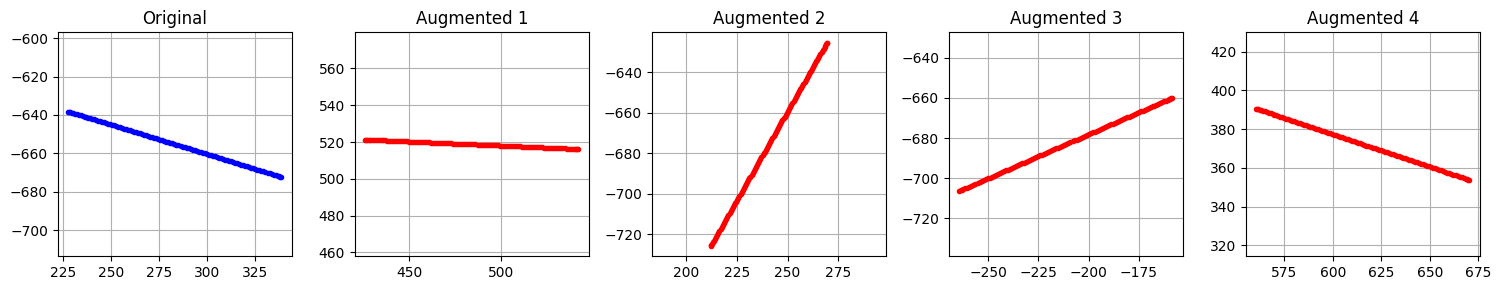

In [4]:
visualize_augmentations(train_data[0], agent_idx=0)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed, Dropout

In [6]:
def standardize_data_dimensions(scenario_data):
    """
    Standardize position data by centering a single scenario at the origin.
    
    :param scenario_data: numpy array of shape (50, 110, 6)
                         where dimensions are [position_x, position_y, velocity_x, velocity_y, heading, object_type]
    :returns: tuple of (standardized_data, min_values)
             - standardized_data: same shape as input with centered positions
             - min_values: array of shape (2,) containing [min_x, min_y] for this scenario
    """
    # Copy the data to avoid modifying the original
    standardized_data = scenario_data.copy()
    
    # Extract position data (first 2 dimensions)
    positions = scenario_data[:, :, :2]  # Shape: (50, 110, 2)
    
    # Create mask for non-zero positions (to ignore padding)
    # We consider a position valid if it's not (0,0) or if the object_type is not 0
    object_types = scenario_data[:, :, 5]  # Shape: (50, 110)
    valid_mask = (positions[:, :, 0] != 0) | (positions[:, :, 1] != 0) | (object_types != 0)
    
    # Find min values across all valid positions in this scenario
    if np.any(valid_mask):
        valid_positions = positions[valid_mask]  # Shape: (num_valid_points, 2)
        min_x = np.min(valid_positions[:, 0])
        min_y = np.min(valid_positions[:, 1])
    else:
        # If no valid positions found, use 0 as min values
        min_x = 0
        min_y = 0
    
    # Store min values
    min_values = np.array([min_x, min_y])
    
    # Standardize positions by subtracting min values
    # Only modify non-zero positions to preserve padding
    for agent_idx in range(scenario_data.shape[0]):
        for time_idx in range(scenario_data.shape[1]):
            if valid_mask[agent_idx, time_idx]:
                standardized_data[agent_idx, time_idx, 0] -= min_x  # position_x
                standardized_data[agent_idx, time_idx, 1] -= min_y  # position_y
    
    return standardized_data, min_values


def denormalize_predictions(predictions, min_values):
    """
    Helper function to add back the min values to predicted positions.
    
    :param predictions: predicted data with standardized positions, shape (50, 110, 6) or similar
    :param min_values: array of shape (2,) containing [min_x, min_y] for this scenario
    :returns: predictions with original coordinate system restored
    """
    denormalized = predictions.copy()
    
    # Add back the min values to restore original coordinate system
    # Assuming predictions have position_x and position_y as first two dimensions
    denormalized[:, :, 0] += min_values[0]  # position_x
    denormalized[:, :, 1] += min_values[1]  # position_y
    
    return denormalized

In [7]:
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

def standardize_single_scene(scene_data):
    """
    Wrapper function to standardize a single scene and return both standardized data and min values.
    This function will be called in parallel.
    """
    standardized_scene, min_vals = standardize_data_dimensions(scene_data)
    return standardized_scene, min_vals

def parallel_standardize_training_data(train_data, n_jobs=-1, verbose=True):
    """
    Parallelize the standardization of training data across all scenes.
    
    :param train_data: numpy array of shape (10000, 50, 110, 6)
    :param n_jobs: number of parallel jobs (-1 uses all available cores)
    :param verbose: whether to show progress bar
    :returns: tuple of (standardized_data, min_values_array)
    """
    print(f"Standardizing {train_data.shape[0]} scenes using {multiprocessing.cpu_count() if n_jobs == -1 else n_jobs} cores...")
    
    # Use joblib to parallelize the processing
    if verbose:
        # With progress bar
        results = Parallel(n_jobs=n_jobs)(
            delayed(standardize_single_scene)(train_data[i]) 
            for i in tqdm(range(train_data.shape[0]), desc="Processing scenes")
        )
    else:
        # Without progress bar
        results = Parallel(n_jobs=n_jobs)(
            delayed(standardize_single_scene)(train_data[i]) 
            for i in range(train_data.shape[0])
        )
    
    # Unpack results
    standardized_scenes, min_values_list = zip(*results)
    
    # Convert to numpy arrays
    standardized_data = np.array(standardized_scenes)
    min_values_array = np.array(min_values_list)
    
    print(f"Standardization complete!")
    print(f"Standardized data shape: {standardized_data.shape}")
    print(f"Min values shape: {min_values_array.shape}")
    
    return standardized_data, min_values_array

In [8]:
# full agents are too much data
num_agents = 15
train_data = train_data[:, :num_agents, :, :]

In [9]:
# Main execution code
augmented_pkl_path = Path("augmented_train.pkl")

# Check if the file exists
if augmented_pkl_path.exists():
    print("Loading augmented data from pickle file...")
    with open(augmented_pkl_path, "rb") as f:
        augmented_train = pickle.load(f)
else:
    print("Augmented data not found. Running augmentation...")
    # Split into 5 chunks
    num_chunks = 5
    chunk_size = len(train_data) // num_chunks
    chunks = [train_data[i * chunk_size: (i + 1) * chunk_size] for i in range(num_chunks - 1)]
    chunks.append(train_data[(num_chunks - 1) * chunk_size:])  # last chunk
    
    augmented_chunks = []
    for i, chunk in enumerate(tqdm(chunks, desc="Processing chunks")):
        print(f"Augmenting chunk {i+1}/{num_chunks}...")
        augmented_chunk = augment_dataset(
            chunk, 
            num_augmentations=2,
            n_jobs=-1,
            batch_size=25
        )
        augmented_chunks.append(augmented_chunk)
        
        # Force cleanup
        del augmented_chunk
        del chunk
        gc.collect()
    
    # Concatenate all augmented chunks
    augmented_train = np.concatenate(augmented_chunks, axis=0)
    print("Augmentation done. Preparing to dump to pickle...")
    
    # Uncomment to save to pickle
    # with open(augmented_pkl_path, "wb") as f:
    #     pickle.dump(augmented_train, f)
    # print("Dumped to pickle.")

print(f"Original shape: {train_data.shape}")
print(f"Augmented shape: {augmented_train.shape}")

Augmented data not found. Running augmentation...


Processing chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Augmenting chunk 1/5...
Using 8 jobs with batch size 25



Augmentations:   0%|          | 0/2 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 1:  10%|█         | 8/80 [00:00<00:00, 78.96it/s]

Processing aug 1:  20%|██        | 16/80 [00:00<00:01, 48.59it/s]

Processing aug 1:  30%|███       | 24/80 [00:00<00:01, 52.25it/s]

Processing aug 1:  50%|█████     | 40/80 [00:00<00:00, 78.89it/s]

Processing aug 1:  90%|█████████ | 72/80 [00:00<00:00, 136.38it/s]

                                                                  
Augmentations:  50%|█████     | 1/2 [00:01<00:01,  1.02s/it]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 2:  60%|██████    | 48/80 [00:00<00:00, 308.52it/s]

                                                                  
Processing chunks:  20%|██        | 1/5 [00:02<00:08,  2.01s/it]

Augmenting chunk 2/5...
Using 8 jobs with batch size 25



Augmentations:   0%|          | 0/2 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 1:  40%|████      | 32/80 [00:00<00:00, 264.67it/s]

Processing aug 1: 100%|██████████| 80/80 [00:00<00:00, 220.31it/s]

                                                                  
Augmentations:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 2:  60%|██████    | 48/80 [00:00<00:00, 289.14it/s]

Processing aug 2: 100%|██████████| 80/80 [00:00<00:00, 279.61it/s]

                                                                  
Processing chunks:  40%|████      | 2/5 [00:03<00:05,  1.82s/it]

Augmenting chunk 3/5...
Using 8 jobs with batch size 25



Augmentations:   0%|          | 0/2 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 1:  40%|████      | 32/80 [00:00<00:00, 223.78it/s]

Processing aug 1: 100%|██████████| 80/80 [00:00<00:00, 222.36it/s]

                                                                  
Augmentations:  50%|█████     | 1/2 [00:00<00:00,  1.26it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 2:  60%|██████    | 48/80 [00:00<00:00, 319.09it/s]

Processing aug 2: 100%|██████████| 80/80 [00:00<00:00, 192.95it/s]

                                                                  
Processing chunks:  60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

Augmenting chunk 4/5...
Using 8 jobs with batch size 25



Augmentations:   0%|          | 0/2 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 1:  40%|████      | 32/80 [00:00<00:00, 289.48it/s]

Processing aug 1:  76%|███████▋  | 61/80 [00:00<00:00, 274.42it/s]

                                                                  
Augmentations:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 2:  60%|██████    | 48/80 [00:00<00:00, 293.53it/s]

Processing aug 2: 100%|██████████| 80/80 [00:00<00:00, 255.33it/s]

                                                                  
Processing chunks:  80%|████████  | 4/5 [00:07<00:01,  1.88s/it]

Augmenting chunk 5/5...
Using 8 jobs with batch size 25



Augmentations:   0%|          | 0/2 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 1:  40%|████      | 32/80 [00:00<00:00, 248.60it/s]

Processing aug 1: 100%|██████████| 80/80 [00:00<00:00, 254.05it/s]

                                                                  
Augmentations:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 2:  60%|██████    | 48/80 [00:00<00:00, 287.65it/s]

                                                                  
Processing chunks: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Augmentation done. Preparing to dump to pickle...
Original shape: (10000, 15, 110, 6)
Augmented shape: (30000, 15, 110, 6)


In [10]:
standardized_train_data, min_values = parallel_standardize_training_data(
    augmented_train, 
    n_jobs=-1,  # Use all available cores
    verbose=True
)
standardized_train_data.shape

Standardizing 30000 scenes using 8 cores...


Processing scenes: 100%|██████████| 30000/30000 [00:21<00:00, 1408.55it/s]


Standardization complete!
Standardized data shape: (30000, 15, 110, 6)
Min values shape: (30000, 2)


(30000, 15, 110, 6)

In [11]:
print('made it')

made it


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

class AgentSelector(layers.Layer):
    """Custom layer to select agent data - serializable"""
    def __init__(self, agent_idx, **kwargs):
        super().__init__(**kwargs)
        self.agent_idx = agent_idx
    
    def call(self, inputs):
        return inputs[:, self.agent_idx, :, :]
    
    def get_config(self):
        config = super().get_config()
        config.update({"agent_idx": self.agent_idx})
        return config

class StackEncodings(layers.Layer):
    """Custom layer to stack encodings - serializable"""
    def call(self, inputs):
        return tf.stack(inputs, axis=1)

class SocialAttentionPooling(layers.Layer):
    """Attention-based social pooling using all 6 features for attention computation"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        # input_shape: [(batch, encoding_dim), (batch, num_agents, encoding_dim), (batch, num_agents, timesteps, 6)]
        encoding_dim = input_shape[0][-1]
        
        # Linear projections for attention
        self.query_projection = Dense(encoding_dim, name='query_proj')
        self.key_projection = Dense(encoding_dim, name='key_proj')  
        self.value_projection = Dense(encoding_dim, name='value_proj')
        
        # Feature attention network to process 6D features
        self.feature_attention = Dense(64, activation='relu', name='feature_attention')
        self.feature_to_encoding = Dense(encoding_dim, name='feature_to_encoding')
        
    def call(self, inputs):
        ego_encoding, all_encodings, all_raw_features = inputs
        
        # Project encodings to attention space
        query = self.query_projection(ego_encoding)  # (batch, encoding_dim)
        keys = self.key_projection(all_encodings)    # (batch, num_agents, encoding_dim)
        values = self.value_projection(all_encodings) # (batch, num_agents, encoding_dim)
        
        # Process raw 6D features for additional attention signal
        # Take mean across timesteps to get representative features per agent
        agent_features = tf.reduce_mean(all_raw_features, axis=2)  # (batch, num_agents, 6)
        
        # Transform 6D features to encoding space
        feature_attention = self.feature_attention(agent_features)  # (batch, num_agents, 64)
        feature_keys = self.feature_to_encoding(feature_attention)  # (batch, num_agents, encoding_dim)
        
        # Compute attention scores using both semantic and feature information
        query_expanded = tf.expand_dims(query, axis=1)  # (batch, 1, encoding_dim)
        
        # Semantic attention scores
        semantic_scores = tf.reduce_sum(query_expanded * keys, axis=-1)  # (batch, num_agents)
        
        # Feature-based attention scores  
        feature_scores = tf.reduce_sum(query_expanded * feature_keys, axis=-1)  # (batch, num_agents)
        
        # Combine both attention signals
        combined_scores = semantic_scores + feature_scores  # (batch, num_agents)
        attention_weights = tf.nn.softmax(combined_scores, axis=-1)  # (batch, num_agents)
        
        # Apply attention weights
        attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)  # (batch, num_agents, 1)
        social_context = tf.reduce_sum(values * attention_weights_expanded, axis=1)  # (batch, encoding_dim)
        
        return social_context

class MultiHeadSocialAttention(layers.Layer):
    """Multi-head attention for social pooling with 6D feature integration"""
    def __init__(self, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
    
    def build(self, input_shape):
        encoding_dim = input_shape[0][-1]
        assert encoding_dim % self.num_heads == 0
        
        self.head_dim = encoding_dim // self.num_heads
        self.encoding_dim = encoding_dim
        
        # Projections for each head
        self.query_projections = [Dense(self.head_dim, name=f'query_head_{i}') 
                                 for i in range(self.num_heads)]
        self.key_projections = [Dense(self.head_dim, name=f'key_head_{i}') 
                               for i in range(self.num_heads)]
        self.value_projections = [Dense(self.head_dim, name=f'value_head_{i}') 
                                 for i in range(self.num_heads)]
        
        # Feature processing for each head
        self.feature_projections = [Dense(self.head_dim, name=f'feature_head_{i}')
                                   for i in range(self.num_heads)]
        
        self.output_projection = Dense(encoding_dim, name='output_proj')
        
        # 6D feature processing
        self.feature_processor = Dense(encoding_dim, activation='relu', name='feature_processor')
    
    def call(self, inputs):
        ego_encoding, all_encodings, all_raw_features = inputs
        
        # Process 6D features
        agent_features = tf.reduce_mean(all_raw_features, axis=2)  # (batch, num_agents, 6)
        processed_features = self.feature_processor(agent_features)  # (batch, num_agents, encoding_dim)
        
        head_outputs = []
        
        for i in range(self.num_heads):
            # Project to query, key, value for this head
            query = self.query_projections[i](ego_encoding)  # (batch, head_dim)
            keys = self.key_projections[i](all_encodings)    # (batch, num_agents, head_dim)
            values = self.value_projections[i](all_encodings) # (batch, num_agents, head_dim)
            
            # Add feature-based keys
            feature_keys = self.feature_projections[i](processed_features)  # (batch, num_agents, head_dim)
            combined_keys = keys + feature_keys
            
            # Compute attention
            query_expanded = tf.expand_dims(query, axis=1)
            attention_scores = tf.reduce_sum(query_expanded * combined_keys, axis=-1) / tf.sqrt(float(self.head_dim))
            attention_weights = tf.nn.softmax(attention_scores, axis=-1)
            
            # Apply attention
            attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)
            head_output = tf.reduce_sum(values * attention_weights_expanded, axis=1)
            head_outputs.append(head_output)
        
        # Concatenate heads and project
        concatenated = tf.concat(head_outputs, axis=-1)
        social_context = self.output_projection(concatenated)
        
        return social_context
    
    def get_config(self):
        config = super().get_config()
        config.update({"num_heads": self.num_heads})
        return config

class PositionAwareSocialAttention(layers.Layer):
    """Attention that uses all 6 dimensions of agent data"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        # input_shape: [(batch, encoding_dim), (batch, num_agents, encoding_dim), (batch, num_agents, timesteps, 6)]
        encoding_dim = input_shape[0][-1]
        
        # Encoding projections
        self.query_projection = Dense(encoding_dim, name='query_proj')
        self.key_projection = Dense(encoding_dim, name='key_proj')
        self.value_projection = Dense(encoding_dim, name='value_proj')
        
        # 6D feature processing layers
        self.position_encoder = Dense(64, activation='relu', name='position_encoder')  # for x,y
        self.velocity_encoder = Dense(64, activation='relu', name='velocity_encoder')  # for vx,vy
        self.heading_encoder = Dense(32, activation='relu', name='heading_encoder')    # for heading
        self.object_type_encoder = Dense(32, activation='relu', name='object_type_encoder')  # for object_type
        
        # Combine all feature encodings
        self.feature_combiner = Dense(encoding_dim, activation='relu', name='feature_combiner')
        
        # Final attention combination
        self.attention_combiner = Dense(1, name='attention_combiner')
        
    def call(self, inputs):
        ego_encoding, all_encodings, all_raw_features = inputs
        
        # Standard attention components
        query = self.query_projection(ego_encoding)
        keys = self.key_projection(all_encodings)
        values = self.value_projection(all_encodings)
        
        # Process 6D features - take mean across timesteps for representative features
        agent_features = tf.reduce_mean(all_raw_features, axis=2)  # (batch, num_agents, 6)
        
        # Split and encode different feature types
        positions = agent_features[:, :, :2]      # x, y
        velocities = agent_features[:, :, 2:4]    # vx, vy  
        headings = agent_features[:, :, 4:5]      # heading
        object_types = agent_features[:, :, 5:6]  # object_type
        
        # Encode each feature type
        pos_encoded = self.position_encoder(positions)      # (batch, num_agents, 64)
        vel_encoded = self.velocity_encoder(velocities)     # (batch, num_agents, 64)
        head_encoded = self.heading_encoder(headings)       # (batch, num_agents, 32)
        type_encoded = self.object_type_encoder(object_types)  # (batch, num_agents, 32)
        
        # Combine all feature encodings
        combined_features = tf.concat([pos_encoded, vel_encoded, head_encoded, type_encoded], axis=-1)
        feature_context = self.feature_combiner(combined_features)  # (batch, num_agents, encoding_dim)
        
        # Compute attention scores
        query_expanded = tf.expand_dims(query, axis=1)
        semantic_scores = tf.reduce_sum(query_expanded * keys, axis=-1, keepdims=True)  # (batch, num_agents, 1)
        feature_scores = tf.reduce_sum(query_expanded * feature_context, axis=-1, keepdims=True)  # (batch, num_agents, 1)
        
        # Combine both types of attention
        combined_scores = tf.concat([semantic_scores, feature_scores], axis=-1)  # (batch, num_agents, 2)
        attention_scores = self.attention_combiner(combined_scores)  # (batch, num_agents, 1)
        attention_scores = tf.squeeze(attention_scores, axis=-1)  # (batch, num_agents)
        
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        
        # Apply attention
        attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)
        social_context = tf.reduce_sum(values * attention_weights_expanded, axis=1)
        
        return social_context

def create_social_lstm_with_attention(input_dim=6, output_dim=2, timesteps_in=50, timesteps_out=60, num_agents=50, lstm_units=128, num_layers=2, lr=0.001, attention_type='simple'):
    """
    Social LSTM with attention-based pooling using all 6 input dimensions
    attention_type: 'simple', 'multihead', or 'position_aware'
    """
    
    # Input: (batch_size, num_agents, timesteps_in, input_dim)
    all_agents_input = Input(shape=(num_agents, timesteps_in, input_dim), name='all_agents_data')
    
    # Create shared encoder layers
    encoder_lstms = []
    for layer_idx in range(num_layers):
        encoder_lstms.append(LSTM(lstm_units, return_sequences=True, name=f'shared_encoder_lstm_{layer_idx}'))
    final_encoder = LSTM(lstm_units, name='shared_final_encoder')
    
    # Encode each agent using shared weights
    agent_encodings = []
    
    for i in range(num_agents):
        agent_data = AgentSelector(agent_idx=i, name=f'agent_{i}_data')(all_agents_input)
        
        # Apply shared encoder layers
        x = agent_data
        for encoder_lstm in encoder_lstms:
            x = encoder_lstm(x)
        encoded = final_encoder(x)
        agent_encodings.append(encoded)
    
    # Stack all encodings
    all_encodings = StackEncodings(name='stack_encodings')(agent_encodings)
    ego_encoding = agent_encodings[0]  # First agent is ego
    
    # Apply attention-based social pooling with 6D features
    if attention_type == 'simple':
        social_context = SocialAttentionPooling(name='social_attention')(
            [ego_encoding, all_encodings, all_agents_input])
    elif attention_type == 'multihead':
        social_context = MultiHeadSocialAttention(num_heads=4, name='multihead_attention')(
            [ego_encoding, all_encodings, all_agents_input])
    elif attention_type == 'position_aware':
        social_context = PositionAwareSocialAttention(name='position_attention')(
            [ego_encoding, all_encodings, all_agents_input])
    else:
        raise ValueError(f"Unknown attention_type: {attention_type}")
    
    # Combine ego encoding with social context
    combined_encoding = layers.Concatenate(name='combine_ego_social')([ego_encoding, social_context])
    
    # Decoder for ego agent
    x = RepeatVector(timesteps_out, name='repeat_for_decode')(combined_encoding)
    
    for layer_idx in range(num_layers):
        x = LSTM(lstm_units, return_sequences=True, name=f'decoder_lstm_{layer_idx}')(x)
    
    # Output layers
    x = TimeDistributed(Dense(128, activation='relu'), name='decode_dense1')(x)
    x = TimeDistributed(Dense(64, activation='relu'), name='decode_dense2')(x)
    ego_output = TimeDistributed(Dense(output_dim), name='ego_trajectory')(x)
    
    # Create model
    model = Model(inputs=all_agents_input, outputs=ego_output, name='AttentionSocialLSTM')
    
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr, clipnorm=1.0),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [13]:
# Updated load_model function with attention layer support
from tensorflow import keras

def load_model(model_path='social_lstm_2.keras'):
    custom_objects = {
        'AgentSelector': AgentSelector,
        'StackEncodings': StackEncodings,
        'SocialAttentionPooling': SocialAttentionPooling,
        'MultiHeadSocialAttention': MultiHeadSocialAttention,
        'PositionAwareSocialAttention': PositionAwareSocialAttention
    }
    
    model = keras.models.load_model(model_path, custom_objects=custom_objects, safe_mode=False)
    print(f"Keras model loaded from {model_path}")
    return model

In [17]:
import tensorflow.keras.backend as K

K.clear_session()

In [18]:
# Simple attention
model = create_social_lstm_with_attention(
    num_agents=15, 
    lstm_units=128, 
    attention_type='simple'
)
# 
# # Multi-head attention
# model_multihead = create_social_lstm_with_attention(
#     num_agents=15, 
#     lstm_units=128, 
#     attention_type='multihead'
# )
# 
# # Position-aware attention (requires position inputs)
# model_position = create_social_lstm_with_attention(
#     num_agents=15, 
#     lstm_units=128, 
#     attention_type='position_aware'
# )
# 
# print("Simple Attention Model:")
# print(model_simple.summary())

In [19]:
model.summary()

Model: "AttentionSocialLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ all_agents_data     │ (None, 15, 50, 6) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_0_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_1_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_2_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_3_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_4_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_5_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_6_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_7_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_8_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_9_data        │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_10_data       │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_11_data       │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_12_data       │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_13_data       │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ agent_14_data       │ (None, 50, 6)     │          0 │ all_agents_data[… │
│ (AgentSelector)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_encoder_lst… │ (None, 50, 128)   │     69,120 │ agent_0_data[0][

 Total params: 744,194 (2.84 MB)

 Trainable params: 744,194 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from keras.src.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.src.optimizers import Adam
from keras import Model
import numpy as np


from tensorflow.keras.callbacks import Callback

class DynamicReduceLROnPlateau(Callback):
    def __init__(self, factor=0.1, patience=3, min_lr=1e-7, verbose=1):
        super().__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_loss = logs.get("val_loss")

        if current_val_loss is None:
            return  # can't do anything if val_loss isn't available

        if current_val_loss < self.best_val_loss - 1e-4:  # a small delta
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(self.model.optimizer.learning_rate.numpy())
                if old_lr > self.min_lr:
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    self.model.optimizer.learning_rate.assign(new_lr)
                    if self.verbose:
                        print(f"\nEpoch {epoch+1}: val_loss did not improve. Reducing LR from {old_lr:.6f} to {new_lr:.6f}")
                    self.wait = 0  # reset after LR reduction

In [21]:
class LRThresholdCallback(Callback):
    def __init__(self, threshold=9e-5):
        super().__init__()
        self.threshold = threshold
        self.should_stop = False

    def on_epoch_end(self, epoch, logs=None):
        lr = float(self.model.optimizer.learning_rate.numpy())
        if lr < self.threshold:
            print(f"\nLearning rate {lr:.6f} < threshold {self.threshold}, moving to Phase 2.")
            self.model.stop_training = True


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class GradientMonitoringCallback(Callback):
    def __init__(self, clip_min=1e-4, clip_max=1e2, monitor_frequency=3):
        """
        Monitor gradient norms during training
        
        Args:
            clip_min: Minimum threshold for gradient norms
            clip_max: Maximum threshold for gradient norms  
            monitor_frequency: How often to check gradients (every N batches)
        """
        print(f"🔧 GradientMonitoringCallback initialized with clip_min={clip_min}, clip_max={clip_max}, monitor_freq={monitor_frequency}")
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.monitor_frequency = monitor_frequency
        self.batch_count = 0
        self.total_calls = 0
        self.gradient_checks = 0
        self.fallback_calls = 0
        
    def on_train_begin(self, logs=None):
        print("🚀 GradientMonitoringCallback: Training started!")
        self.batch_count = 0
        self.total_calls = 0
        self.gradient_checks = 0
        self.fallback_calls = 0
        
    # def on_epoch_begin(self, epoch, logs=None):
    #     print(f"📍 GradientMonitoringCallback: Starting epoch {epoch + 1}")
        
    # def on_train_batch_begin(self, batch, logs=None):
    #     # Just to prove we're being called
    #     if batch % 50 == 0:  # Print every 50 batches to avoid spam
    #         print(f"⚡ GradientMonitoringCallback: Batch {batch} starting")
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        self.total_calls += 1
        
        # Print every time to show we're being called
        # if batch % 50 == 0:  # Print every 50 batches
            # print(f"📊 GradientMonitoringCallback: Batch {batch} ended (total calls: {self.total_calls})")
        
        # Only monitor every N batches to avoid performance overhead
        if self.batch_count % self.monitor_frequency != 0:
            return
            
        # print(f"🔍 GradientMonitoringCallback: Checking gradients at batch {batch} (check #{self.gradient_checks + 1})")
        
        # Get gradients from the optimizer's current state
        try:
            # Access the model's optimizer to get gradient information
            optimizer = self.model.optimizer
            print(f"   📋 Optimizer type: {type(optimizer).__name__}")
            
            # Get trainable variables
            trainable_vars = self.model.trainable_variables
            print(f"   📈 Number of trainable variables: {len(trainable_vars)}")
            
            if hasattr(optimizer, 'get_gradients'):
                print("   ✅ Optimizer has get_gradients method")
                # For some optimizers, we can access gradients directly
                grads = optimizer.get_gradients(self.model.total_loss, trainable_vars)
                print(f"   📊 Retrieved {len([g for g in grads if g is not None])} gradients")
            else:
                print("   ❌ Optimizer doesn't have get_gradients, using variable norms")
                # Alternative approach: check the current variable states
                grad_norms = []
                for i, var in enumerate(trainable_vars):
                    if var is not None:
                        var_norm = tf.norm(var)
                        grad_norms.append(var_norm)
                        if i < 3:  # Print first 3 for debugging
                            print(f"      Variable {i} norm: {float(var_norm.numpy()):.2e}")
                
                self._check_norms(grad_norms, "Variable")
                self.gradient_checks += 1
                return
                
            # Compute gradient norms
            grad_norms = []
            for i, grad in enumerate(grads):
                if grad is not None:
                    grad_norm = tf.norm(grad)
                    grad_norms.append(grad_norm)
                    if i < 3:  # Print first 3 for debugging
                        print(f"      Gradient {i} norm: {float(grad_norm.numpy()):.2e}")
                    
            print(f"   ✅ Computed {len(grad_norms)} gradient norms")
            self._check_norms(grad_norms, "Gradient")
            self.gradient_checks += 1
            
        except Exception as e:
            print(f"   ❌ Exception in gradient monitoring: {str(e)}")
            self.fallback_calls += 1
            # Fallback: just monitor the loss for signs of instability
            print('   🔄 Fallback: monitoring loss only')
            if logs:
                loss_value = logs.get('loss', 0)
                print(f"   📉 Current loss: {loss_value:.2e}")
                if np.isnan(loss_value) or np.isinf(loss_value):
                    print(f"   ⚠️  WARNING: Loss became {loss_value} at batch {batch}")
                elif loss_value > 1e6:
                    print(f"   ⚠️  WARNING: Very large loss {loss_value:.2e} at batch {batch}")
    
    def _check_norms(self, norms, norm_type="Gradient"):
        """Check if norms are within acceptable range"""
        print(f"   🔬 Checking {len(norms)} {norm_type.lower()} norms...")
        warnings = 0
        
        for idx, norm in enumerate(norms):
            try:
                norm_value = float(norm.numpy()) if hasattr(norm, 'numpy') else float(norm)
                
                if norm_value > self.clip_max:
                    print(f"   ⚠️  WARNING: {norm_type} norm {norm_value:.2e} is too large (layer {idx})")
                    warnings += 1
                elif norm_value < self.clip_min:
                    print(f"   ⚠️  WARNING: {norm_type} norm {norm_value:.2e} is too small (layer {idx})")
                    warnings += 1
                elif np.isnan(norm_value) or np.isinf(norm_value):
                    print(f"   ⚠️  WARNING: {norm_type} norm is {norm_value} (layer {idx})")
                    warnings += 1
                    
            except Exception as e:
                print(f"   ❌ Cannot convert norm to float for layer {idx}: {str(e)}")
                continue
                
        if warnings == 0:
            print(f"   ✅ All {norm_type.lower()} norms are within acceptable range")
        else:
            print(f"   ⚠️  Found {warnings} norm warnings")
    
    # def on_epoch_end(self, epoch, logs=None):
    #     """Print summary at end of each epoch"""
    #     print(f"📈 GradientMonitoringCallback: Epoch {epoch + 1} completed")
    #     print(f"   📊 Total batch calls: {self.total_calls}")
    #     print(f"   🔍 Gradient checks performed: {self.gradient_checks}")
    #     print(f"   🔄 Fallback calls: {self.fallback_calls}")
    #     
    #     if logs:
    #         loss = logs.get('loss', 0)
    #         val_loss = logs.get('val_loss', 0)
    #         print(f"   📉 Final epoch loss: {loss:.2e}")
    #         if val_loss:
    #             print(f"   📉 Final epoch val_loss: {val_loss:.2e}")
    #         
    #         if np.isnan(loss) or np.isinf(loss):
    #             print(f"   ⚠️  WARNING: Training loss became unstable: {loss}")
    #         if val_loss and (np.isnan(val_loss) or np.isinf(val_loss)):
    #             print(f"   ⚠️  WARNING: Validation loss became unstable: {val_loss}")
        
    def on_train_end(self, logs=None):
        print("🏁 GradientMonitoringCallback: Training completed!")
        print(f"   📊 Final stats - Total calls: {self.total_calls}, Gradient checks: {self.gradient_checks}, Fallbacks: {self.fallback_calls}")
        
        if self.total_calls == 0:
            print("   ❌ ERROR: Callback was never called! Check if it's properly added to callbacks list.")
        elif self.gradient_checks == 0 and self.fallback_calls == 0:
            print("   ⚠️  WARNING: No gradient monitoring was performed. Check monitor_frequency setting.")
        else:
            print("   ✅ Gradient monitoring completed successfully!")

In [23]:
from keras.src.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.src.optimizers import Adam
from keras import Model
import numpy as np


def exponential_decay_schedule(epoch, lr):
    decay_rate = 0.9
    decay_steps = 5
    if epoch % decay_steps == 0 and epoch:
        print('Learning rate update:', lr * decay_rate)
        return lr * decay_rate
    return lr


# Custom callback to monitor LR and stop training
class LRThresholdCallback(Callback):
    def __init__(self, threshold=9e-5):
        super().__init__()
        self.threshold = threshold
        self.should_stop = False

    def on_epoch_end(self, epoch, logs=None):
        lr = float(self.model.optimizer.learning_rate.numpy())
        if lr < self.threshold:
            print(f"\nLearning rate {lr:.6f} < threshold {self.threshold}, moving to next phase.")
            self.model.stop_training = True



In [24]:
class DynamicReduceLROnPlateau(Callback):
    def __init__(self, factor=0.1, patience=3, min_lr=1e-7, verbose=1):
        super().__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_loss = logs.get("val_loss")

        if current_val_loss is None:
            return  # can't do anything if val_loss isn't available

        if current_val_loss < self.best_val_loss - 1e-4:  # a small delta
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(self.model.optimizer.learning_rate.numpy())
                if old_lr > self.min_lr:
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    self.model.optimizer.learning_rate.assign(new_lr)
                    if self.verbose:
                        print(f"\nEpoch {epoch+1}: val_loss did not improve. Reducing LR from {old_lr:.6f} to {new_lr:.6f}")
                    self.wait = 0  # reset after LR reduction


In [25]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import save_model

class SaveBestModelCallback(Callback):
    def __init__(self, save_path='best_model', monitor='val_loss'):
        super().__init__()
        self.best = float('inf')
        self.monitor = monitor
        self.save_path = save_path
        
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None and current < self.best:
            self.best = current
            print(f"\nNew best {self.monitor}: {current:.6f}. Saving model...")
            self.model.save(self.save_path+'.keras', overwrite=True)


In [26]:
def train_model(train_data, batch_size=32, validation_split=0.2, Tobs=50, Tpred=60,
                             epochs1=50, epochs2=50, lr1=0.001, lr2=0.000001):
    """Version that predicts deltas instead of absolute positions"""
    n_scenarios = train_data.shape[0]
    
    X_train_scenarios = []
    y_train_deltas = []
    
    pruned_ego_sparse = 0
    
    for i in range(n_scenarios):
        scenario_data = train_data[i]  # (50_agents, 110_timesteps, 6_features)
        
        # Extract ego data
        ego_data = scenario_data[0, :, :]
        ego_observed = ego_data[:Tobs]
        ego_future = ego_data[Tobs:Tobs + Tpred, :2]
        
        # Check ego data quality
        ego_obs_zero_ratio = np.mean(np.all(ego_observed == 0, axis=1))
        ego_future_zero_ratio = np.mean(np.all(ego_future == 0, axis=1))
        
        if ego_obs_zero_ratio > 0.3 or ego_future_zero_ratio > 0.3:
            pruned_ego_sparse += 1
            continue
        
        # Compute deltas
        last_obs_pos = ego_observed[-1, :2]
        delta = np.diff(np.vstack([last_obs_pos, ego_future]), axis=0)  # (60, 2)
        
        # Input: all agents' observed data
        scenario_input = scenario_data[:, :Tobs, :]
        
        X_train_scenarios.append(scenario_input)
        y_train_deltas.append(delta)
    
    print(f"Valid scenarios: {len(X_train_scenarios)}")
    print(f"Pruned due to sparse ego data: {pruned_ego_sparse}")
    
    X_train = np.array(X_train_scenarios)
    y_train = np.array(y_train_deltas)
    
    # --- Normalize Input and Output ---
    X_mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape: (1, 1, 6)
    X_std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

    y_mean = y_train.mean(axis=(0, 1), keepdims=True)  # shape: (1, 1, 2)
    y_std = y_train.std(axis=(0, 1), keepdims=True) + 1e-8

    X_train = (X_train - X_mean) / X_std
    y_train = (y_train - y_mean) / y_std
    
    print(f"Input shape: {X_train.shape}, Delta output shape: {y_train.shape}")
    
    model = create_social_lstm_with_attention(
    num_agents=num_agents, 
    lstm_units=128, 
    timesteps_in=Tobs,
    timesteps_out=Tpred,
    attention_type='simple',
    lr=lr1
    )
    
    # Callbacks
    save_best_callback = SaveBestModelCallback(
        save_path='attention_social_lstm',
        monitor='val_loss'
    )
    
    phase1_callbacks = [
        DynamicReduceLROnPlateau(factor=0.7, patience=3, min_lr=1e-9),
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        LRThresholdCallback(threshold=9e-8),
        save_best_callback
    ]
    
    print("\n--- Phase 1: Training ---")
    model.fit(
        X_train, y_train,
        epochs=epochs1,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=phase1_callbacks,
        verbose=1
    )
    
    print("\n--- Phase 2: Fine-tuning ---")
    model.compile(
        optimizer=Adam(
            learning_rate=lr2,
            clipnorm=0.1,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        ),
        loss='mse',
        metrics=['mae']
    )
    
    phase2_callbacks = [
        EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss'),
        DynamicReduceLROnPlateau(factor=0.7, patience=3, min_lr=1e-9),
        LRThresholdCallback(threshold=9e-8)
    ]
    
    model.fit(
        X_train, y_train,
        epochs=epochs2,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=phase2_callbacks,
        verbose=1
    )
    
    return model, X_mean, X_std, y_mean, y_std

In [27]:
def plot_mae_by_timestep(y_true, y_pred):
    """
    Visualize MAE across timesteps in the prediction horizon.
    
    Args:
        y_true (np.ndarray): shape (N, Tpred, 2)
        y_pred (np.ndarray): shape (N, Tpred, 2)
    """
    mae_per_timestep = np.mean(np.abs(y_true - y_pred), axis=(0, 2))  # shape (Tpred,)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(mae_per_timestep, label='MAE per Timestep')
    plt.xlabel('Timestep')
    plt.ylabel('MAE (meters)')
    plt.title('Mean Absolute Error Over Prediction Horizon')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [28]:
import numpy as np

def reconstruct_absolute_positions(pred_deltas, last_observed_positions):
    """
    Reconstruct absolute predicted positions in an autoregressive way.
    
    Args:
        pred_deltas: np.ndarray of shape (N, Tpred, 2)
        last_observed_positions: np.ndarray of shape (N, 2)
    
    Returns:
        np.ndarray of shape (N, Tpred, 2)
    """
    N, Tpred, _ = pred_deltas.shape
    positions = np.zeros((N, Tpred, 2), dtype=pred_deltas.dtype)
    positions[:, 0, :] = last_observed_positions + pred_deltas[:, 0, :]
    
    for t in range(1, Tpred):
        positions[:, t, :] = positions[:, t-1, :] + pred_deltas[:, t, :]
    
    return positions

In [29]:
def forecast_positions(scenario_data, Tobs, Tpred, model, X_mean=None, X_std=None, y_mean=None, y_std=None):
    """
    Use social LSTM model to forecast future deltas for ego agent using all agents' context
    
    Args:
        scenario_data (numpy.ndarray): Shape (50_agents, time_steps, 6_dimensions)
        Tobs (int): Number of observed time steps (50)
        Tpred (int): Number of future time steps to predict (60)
        model (Model): Trained social LSTM model
        X_mean, X_std: Optional normalization stats for input
        y_mean, y_std: Optional normalization stats for output
    
    Returns:
        numpy.ndarray: Predicted absolute positions of shape (Tpred, 2)
    """
    
    # Prepare input: all agents' observed trajectories
    # Shape: (50_agents, Tobs, 6_features)
    all_agents_obs = scenario_data[:, :Tobs, :].copy()
    
    # Add batch dimension: (1, 50_agents, Tobs, 6_features)
    X_pred = np.expand_dims(all_agents_obs, axis=0)
    
    # Normalize if stats are provided
    if X_mean is not None and X_std is not None:
        X_pred = (X_pred - X_mean) / X_std
    
    # Predict deltas for ego agent
    pred_deltas = model.predict(X_pred, verbose=0)  # shape (1, Tpred, 2)
    
    # print("pred deltas shape:", pred_deltas.shape)
    # print("pred deltas sample:", pred_deltas[0, :5, :])  # First 5 timesteps
    
    # Denormalize if stats are provided
    if y_mean is not None and y_std is not None:
        pred_deltas = pred_deltas * y_std + y_mean
    
    # Get ego's last observed position
    ego_data = scenario_data[0, :Tobs, :]  # Ego is agent 0
    last_pos = ego_data[Tobs - 1, :2]  # shape (2,)
    
    # Reconstruct absolute positions
    abs_positions = reconstruct_absolute_positions(
        pred_deltas=pred_deltas,
        last_observed_positions=np.expand_dims(last_pos, axis=0)
    )[0]  # Remove batch dimension
    
    return abs_positions

def reconstruct_absolute_positions(pred_deltas, last_observed_positions):
    """
    Reconstruct absolute predicted positions in an autoregressive way.
    
    Args:
        pred_deltas: np.ndarray of shape (N, Tpred, 2)
        last_observed_positions: np.ndarray of shape (N, 2)
    
    Returns:
        np.ndarray of shape (N, Tpred, 2)
    """
    N, Tpred, _ = pred_deltas.shape
    positions = np.zeros((N, Tpred, 2), dtype=pred_deltas.dtype)
    positions[:, 0, :] = last_observed_positions + pred_deltas[:, 0, :]
    
    for t in range(1, Tpred):
        positions[:, t, :] = positions[:, t-1, :] + pred_deltas[:, t, :]
    
    return positions

# Batch processing version for efficiency
def forecast_multiple_scenarios(scenarios_data, Tobs, Tpred, model, X_mean=None, X_std=None, y_mean=None, y_std=None):
    """
    Forecast positions for multiple scenarios at once
    
    Args:
        scenarios_data: Shape (n_scenarios, 50_agents, time_steps, 6_features)
        
    Returns:
        numpy.ndarray: Shape (n_scenarios, Tpred, 2)
    """
    n_scenarios = scenarios_data.shape[0]
    
    # Prepare batch input
    X_batch = scenarios_data[:, :, :Tobs, :].copy()  # (n_scenarios, 50_agents, Tobs, 6)
    
    # Normalize if needed
    if X_mean is not None and X_std is not None:
        X_batch = (X_batch - X_mean) / X_std
    
    # Batch prediction
    pred_deltas_batch = model.predict(X_batch, verbose=0)  # (n_scenarios, Tpred, 2)
    
    # Denormalize
    if y_mean is not None and y_std is not None:
        pred_deltas_batch = pred_deltas_batch * y_std + y_mean
    
    # Get last observed positions for all scenarios (ego agent only)
    last_positions = scenarios_data[:, 0, Tobs-1, :2]  # (n_scenarios, 2)
    
    # Reconstruct positions for all scenarios
    abs_positions_batch = reconstruct_absolute_positions(
        pred_deltas=pred_deltas_batch,
        last_observed_positions=last_positions
    )
    
    return abs_positions_batch

In [30]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def make_gif(data_matrix1, data_matrix2, name='comparison'):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation

    cmap1 = plt.cm.get_cmap('viridis', 50)
    cmap2 = plt.cm.get_cmap('plasma', 50)

    assert data_matrix1.shape[1] == data_matrix2.shape[1], "Both matrices must have same number of timesteps"
    timesteps = data_matrix1.shape[1]

    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    ax1, ax2 = axes

    def update(frame):
        for ax in axes:
            ax.clear()

        for i in range(data_matrix1.shape[0]):
            for (data_matrix, ax, cmap) in [(data_matrix1, ax1, cmap1), (data_matrix2, ax2, cmap2)]:
                x = data_matrix[i, frame, 0]
                y = data_matrix[i, frame, 1]
                if x != 0 and y != 0:
                    xs = data_matrix[i, :frame+1, 0]
                    ys = data_matrix[i, :frame+1, 1]
                    mask = (xs != 0) & (ys != 0)
                    xs = xs[mask]
                    ys = ys[mask]
                    if len(xs) > 0 and len(ys) > 0:
                        color = cmap(i)
                        ax.plot(xs, ys, alpha=0.9, color=color)
                        ax.scatter(x, y, s=80, color=color)

        # Plot ego vehicle (index 0) on both
        ax1.plot(data_matrix1[0, :frame, 0], data_matrix1[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax1.scatter(data_matrix1[0, frame, 0], data_matrix1[0, frame, 1], s=80, color='tab:orange')
        ax1.set_title('Prediction')

        ax2.plot(data_matrix2[0, :frame, 0], data_matrix2[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax2.scatter(data_matrix2[0, frame, 0], data_matrix2[0, frame, 1], s=80, color='tab:orange')
        ax2.set_title('Actual')

        for ax, data_matrix in zip(axes, [data_matrix1, data_matrix2]):
            ax.set_xlim(data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].min() - 10,
                        data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].max() + 10)
            ax.set_ylim(data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].min() - 10,
                        data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].max() + 10)
            ax.legend()
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        # Compute MSE over non-zero entries up to current frame
        mask = (data_matrix2[:, :frame+1, :] != 0) & (data_matrix1[:, :frame+1, :] != 0)
        mse = np.mean((data_matrix1[:, :frame+1, :][mask] - data_matrix2[:, :frame+1, :][mask]) ** 2)

        fig.suptitle(f"Timestep {frame} - MSE: {mse:.4f}", fontsize=16)
        return ax1.collections + ax1.lines + ax2.collections + ax2.lines

    anim = animation.FuncAnimation(fig, update, frames=list(range(0, timesteps, 3)), interval=100, blit=True)
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()


In [31]:
# # figure out stats
# def stats():
#     Tobs = 50
#     Tpred = 60
#     n_scenarios = train_data.shape[0]
#     X_train_raw = []
#     y_train_deltas = []
# 
#     for i in range(n_scenarios):
#         ego_data = train_data[i, 0, :, :]
#         if np.all(ego_data == 0):
#             continue
# 
#         observed = ego_data[:Tobs]            # shape (50, 6)
#         future = ego_data[Tobs:Tobs+Tpred, :2]
#         last_obs_pos = observed[-1, :2]
# 
#         if np.any(np.all(observed == 0, axis=1)) or np.any(np.all(future == 0, axis=1)):
#             continue
# 
#         # Compute deltas w.r.t. previous future timestep
#         delta = np.diff(np.vstack([last_obs_pos, future]), axis=0)  # (60, 2)
# 
#         X_train_raw.append(observed)
#         y_train_deltas.append(delta)
# 
# 
#     X_train = np.array(X_train_raw)
#     y_train = np.array(y_train_deltas)
# 
#     print(f"{X_train.shape[0]} valid sequences.")
#     print(f"Input shape: {X_train.shape}, Delta Output shape: {y_train.shape}")
# 
#     # --- Normalize Input and Output ---
#     X_mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape: (1, 1, 6)
#     X_std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8
# 
#     y_mean = y_train.mean(axis=(0, 1), keepdims=True)  # shape: (1, 1, 2)
#     y_std = y_train.std(axis=(0, 1), keepdims=True) + 1e-8
# 
#     X_train = (X_train - X_mean) / X_std
#     y_train = (y_train - y_mean) / y_std
#     return X_mean, X_std, y_mean, y_std
# X_mean, X_std, y_mean, y_std = stats()

In [32]:
K.clear_session()

In [ ]:
# fit
model, X_mean, X_std, y_mean, y_std = train_model(standardized_train_data[:],epochs1=200, epochs2=100, validation_split=0.2, lr1=0.0003, lr2=0.00001)

Valid scenarios: 30000
Pruned due to sparse ego data: 0
Input shape: (30000, 15, 50, 6), Delta output shape: (30000, 60, 2)

--- Phase 1: Training ---
Epoch 1/200


2025-06-01 12:25:36.991171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 0.2572 - mae: 0.3328
New best val_loss: 0.136776. Saving model...
750/750 ━━━━━━━━━━━━━━━━━━━━ 316s 401ms/step - loss: 0.2571 - mae: 0.3328 - val_loss: 0.1368 - val_mae: 0.2420
Epoch 2/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 234s 311ms/step - loss: 0.1382 - mae: 0.2461 - val_loss: 0.2449 - val_mae: 0.3748
Epoch 3/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 228s 304ms/step - loss: 0.2101 - mae: 0.3278 - val_loss: 0.1610 - val_mae: 0.2726
Epoch 4/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1401 - mae: 0.2532
Epoch 4: val_loss did not improve. Reducing LR from 0.000300 to 0.000210
750/750 ━━━━━━━━━━━━━━━━━━━━ 238s 317ms/step - loss: 0.1401 - mae: 0.2533 - val_loss: 0.1555 - val_mae: 0.2715
Epoch 5/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 257s 342ms/step - loss: 0.2250 - mae: 0.3316 - val_loss: 0.2892 - val_mae: 0.3637
Epoch 6/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 347s 462ms/step - loss: 0.4287 - mae: 0.4734 - val_loss: 0.1976 - val_mae: 0.3178

--- Phase 2

In [ ]:
model = load_model()

In [ ]:
# visualize regular prediction

# X_mean, X_std, y_mean, y_std = None, None, None, None

# model = load_model()

# Parameters
Tobs = 50
Tpred = 60

data = standardized_train_data[6325]

# Select a test scenario (can use any valid index)
test_scenario = data.copy()  # shape (agents, time_steps, features)


# Forecast future positions
predicted_positions = forecast_positions(test_scenario, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std)

# Create combined matrix of past observed + predicted for ego agent (agent 0)
ego_past = test_scenario[0, :Tobs, :2]               # shape (Tobs, 2)
ego_future = predicted_positions                     # shape (Tpred, 2)

print(ego_future[:5])
print(test_scenario[0, Tobs:Tobs+5, :2])
ego_full = np.concatenate([ego_past, ego_future], axis=0)  # shape (Tobs + Tpred, 2)

# Create updated scenario with predicted ego and original others
updated_scenario = test_scenario.copy()
updated_scenario[0, :Tobs+Tpred, :2] = ego_full  # Replace ego trajectory

# Visualize
make_gif(updated_scenario, data, name='lstmsocial')

In [ ]:
# # visualize prediction
# 
# # model = load_model()
# 
# # Parameters
# Tobs = 50
# Tpred = 60
# 
# data = train_data[0]
# 
# # Select a test scenario (can use any valid index)
# test_scenario = data.copy()  # shape (agents, time_steps, features)
# 
# 
# # Forecast future positions
# predicted_positions = finetune_forecast_positions(test_scenario, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std)
# 
# # Create combined matrix of past observed + predicted for ego agent (agent 0)
# ego_past = test_scenario[0, :Tobs, :2]               # shape (Tobs, 2)
# ego_future = predicted_positions[0]                  # shape (Tpred, 2)
# ego_full = np.concatenate([ego_past, ego_future], axis=0)  # shape (Tobs + Tpred, 2)
# 
# # Create updated scenario with predicted ego and original others
# updated_scenario = test_scenario.copy()
# updated_scenario[0, :Tobs+Tpred, :2] = ego_full  # Replace ego trajectory
# 
# # Visualize
# make_gif(updated_scenario, data, name='lstm2')

In [ ]:

from sklearn.metrics import mean_squared_error

def evaluate_mse(train_data, model, Tobs=50, Tpred=60, X_mean=None, X_std=None, y_mean=None, y_std=None):
    """
    Computes LSTM prediction for ego agent and evaluates MSE with progress reporting.
    """
    N = train_data.shape[0]
    mse_list = []
    valid_scenarios = 0
    
    print(f"Evaluating {N} scenarios...")
    
    # Progress reporting variables
    report_interval = max(1, N // 10)  # Report at 10% intervals
    
    for i in range(N):
        # Progress reporting
        if i % report_interval == 0 or i == N-1:
            print(f"Processing scenario {i+1}/{N} ({(i+1)/N*100:.1f}%)")
        
        scenario_data = train_data[i]  # Shape: (50_agents, time_steps, 6)
        ego_agent_data = scenario_data[0]  # Shape: (time_steps, 6)
        ground_truth = ego_agent_data[Tobs:Tobs+Tpred, :2]
        
        # Skip if ground truth contains all zeros (padded)
        if np.all(ground_truth == 0):
            continue
            
        valid_scenarios += 1
        
        # Forecast future positions - pass full scenario_data, not just ego
        predicted_positions = forecast_positions(
            scenario_data,  # Pass full scenario (50_agents, time_steps, 6)
            Tobs, Tpred, model, X_mean, X_std, y_mean, y_std
        )
        
        # Compute MSE
        mse = mean_squared_error(ground_truth, predicted_positions)
        mse_list.append(mse)
        
        # Occasional MSE reporting
        if i % report_interval == 0:
            print(f"  Current scenario MSE: {mse:.4f}")
    
    # Final results
    if mse_list:
        overall_mse = np.mean(mse_list)
        print(f"Evaluation complete: {valid_scenarios} valid scenarios")
        print(f"Mean Squared Error (MSE): {overall_mse:.4f}")
        print(f"Min MSE: {np.min(mse_list):.4f}, Max MSE: {np.max(mse_list):.4f}")
        return overall_mse
    else:
        print("No valid scenarios for evaluation.")
        return None

In [ ]:
# Evaluate on training data
evaluate_mse(standardized_train_data[:300], model, Tobs, Tpred, X_mean, X_std, y_mean, y_std)

In [ ]:
import pandas as pd
import numpy as np

def generate_social_lstm_submission(data, model, output_csv, Tobs=50, Tpred=60, 
                                  X_mean=None, X_std=None, y_mean=None, y_std=None):
    """
    Applies social LSTM forecasting and generates a submission CSV.
    
    Args:
        data (np.ndarray): Test data of shape (num_scenarios, 50, time_steps, 6).
        model: Trained social LSTM model.
        output_csv (str): Output CSV file path.
        Tobs (int): Observed time steps (default 50).
        Tpred (int): Prediction time steps (default 60).
        X_mean, X_std, y_mean, y_std: Normalization parameters from training
    """
    predictions = []
    
    print(f"Generating predictions for {data.shape[0]} scenarios...")
    
    for i in range(data.shape[0]):
        if i % max(1, data.shape[0] // 10) == 0:
            print(f"Processing scenario {i+1}/{data.shape[0]}")
            
        scenario_data = data[i]  # Shape: (50, time_steps, 6)
        
        # 1. Standardize the scenario data (min-centering)
        standardized_data, min_values = standardize_data_dimensions(scenario_data)
        
        # 2. Use forecast_positions with standardized data
        predicted_positions = forecast_positions(
            standardized_data, Tobs, Tpred, model, 
            X_mean, X_std, y_mean, y_std
        )  # Shape: (Tpred, 2)
        
        # 3. Denormalize predictions (add back min values)
        denormalized_predictions = denormalize_predictions_2d(predicted_positions, min_values)
        
        # 4. Append predictions for this scenario
        predictions.extend(denormalized_predictions)
    
    # Create DataFrame
    submission_df = pd.DataFrame(predictions, columns=["x", "y"])
    submission_df.index.name = 'index'
    
    # Save CSV with index
    submission_df.to_csv(output_csv)
    print(f"Submission file '{output_csv}' saved with shape {submission_df.shape}")

def denormalize_predictions_2d(predictions, min_values):
    """
    Helper function to add back the min values to predicted positions (2D version).
    
    :param predictions: predicted data with standardized positions, shape (Tpred, 2)
    :param min_values: array of shape (2,) containing [min_x, min_y] for this scenario
    :returns: predictions with original coordinate system restored
    """
    denormalized = predictions.copy()
    
    # Add back the min values to restore original coordinate system
    denormalized[:, 0] += min_values[0]  # position_x
    denormalized[:, 1] += min_values[1]  # position_y
    
    return denormalized

In [ ]:
generate_social_lstm_submission(test_data, model, 'attention_social_lstm.csv',
                               X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std)